In [1]:
#Auto reload modules when code is changed
%load_ext autoreload
%autoreload 2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
import os
import torch.nn as nn 
import torch 
import yaml 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from torch.utils.data import Dataset, DataLoader
import random
from laserscan import LaserScan
from collections import OrderedDict
import matplotlib.pyplot as plt
from ModelContainer import ModelContainer


In [2]:
# Code adapted from SalsaNext @ Tiago Cortinhal 
class ClaSeKDataset(Dataset):

    def __init__(self, root,  # directory where data is
                 split,  # train or test
                 df, # pandas dataframe containing filename and label
                 label_dict,  # label dict: (e.g 10: "car")
                 sensor,  # sensor to parse scans from
                 max_points=150000,  # max number of points present in dataset
                 gt=True,
                 transform=False):
        # save deats
        self.root = os.path.join(root, split)
        self.label_dict = label_dict
        self.df = df
        self.sensor = sensor
        self.sensor_img_H = sensor["img_prop"]["height"]
        self.sensor_img_W = sensor["img_prop"]["width"]
        self.sensor_img_means = torch.tensor(sensor["img_means"],
                                             dtype=torch.float)
        self.sensor_img_stds = torch.tensor(sensor["img_stds"],
                                            dtype=torch.float)
        self.sensor_fov_up = sensor["fov_up"]
        self.sensor_fov_down = sensor["fov_down"]
        self.max_points = max_points
        self.gt = gt
        self.transform = transform

        self.nclasses = len(label_dict.keys())

        # make sure directory exists
        if os.path.isdir(self.root):
            print("Sequences folder exists! Using sequences from %s" % self.root)
        else:
            raise ValueError("Sequences folder doesn't exist! Exiting...")

        # make sure labels is a dict
        assert (isinstance(self.label_dict, dict))

    def __getitem__(self, index):
        # get item in tensor shape
        item = self.df.iloc[index]

        scan_file = os.path.join(self.root, item.FNAME)

        if self.gt:
            label = item.LABEL
        else:
            label = 0

        # open a semantic laserscan
        DA = False
        flip_sign = False
        rot = False
        drop_points = False
        if self.transform:
            if random.random() > 0.5:
                if random.random() > 0.5:
                    DA = True
                if random.random() > 0.5:
                    flip_sign = True
                if random.random() > 0.5:
                    rot = True
                drop_points = random.uniform(0, 0.5)

        scanner_class = LaserScan

        scan = scanner_class(project=True,
                                 H=self.sensor_img_H,
                                 W=self.sensor_img_W,
                                 fov_up=self.sensor_fov_up,
                                 fov_down=self.sensor_fov_down,
                                 DA=DA,
                                 rot=rot,
                                 flip_sign=flip_sign,
                                 drop_points=drop_points)


        scan.open_scan(scan_file)
        # make a tensor of the uncompressed data (with the max num points)
        unproj_n_points = scan.points.shape[0]
        if unproj_n_points < self.max_points:
            points_to_copy = unproj_n_points
        else:
            points_to_copy = self.max_points

        unproj_xyz = torch.full((self.max_points, 3), -1.0, dtype=torch.float)
        unproj_xyz[:points_to_copy] = torch.from_numpy(scan.points[: points_to_copy])
        unproj_range = torch.full([self.max_points], -1.0, dtype=torch.float)
        unproj_range[: points_to_copy] = torch.from_numpy(scan.unproj_range[: points_to_copy])
        unproj_remissions = torch.full([self.max_points], -1.0, dtype=torch.float)
        unproj_remissions[: points_to_copy] = torch.from_numpy(scan.remissions[: points_to_copy])

        # get points and labels
        proj_range = torch.from_numpy(scan.proj_range).clone()
        proj_xyz = torch.from_numpy(scan.proj_xyz).clone()
        proj_remission = torch.from_numpy(scan.proj_remission).clone()
        proj_mask = torch.from_numpy(scan.proj_mask)

        proj_x = torch.full([self.max_points], -1, dtype=torch.long)
        proj_x[: points_to_copy] = torch.from_numpy(scan.proj_x[: points_to_copy])
        proj_y = torch.full([self.max_points], -1, dtype=torch.long)
        proj_y[: points_to_copy] = torch.from_numpy(scan.proj_y[: points_to_copy])
        proj = torch.cat([proj_range.unsqueeze(0).clone(),
                          proj_xyz.clone().permute(2, 0, 1),
                          proj_remission.unsqueeze(0).clone()])
        proj = (proj - self.sensor_img_means[:, None, None]
                ) / self.sensor_img_stds[:, None, None]
        proj = proj * proj_mask.float()

        # return
        return proj, label, index

    def __len__(self):
        return self.df.shape[0]

    @staticmethod
    def map(label, mapdict):
        # put label from original values to xentropy
        # or vice-versa, depending on dictionary values
        # make learning map a lookup table
        maxkey = 0
        for key, data in mapdict.items():
            if isinstance(data, list):
                nel = len(data)
            else:
                nel = 1
            if key > maxkey:
                maxkey = key
        # +100 hack making lut bigger just in case there are unknown labels
        if nel > 1:
            lut = np.zeros((maxkey + 100, nel), dtype=np.int32)
        else:
            lut = np.zeros((maxkey + 100), dtype=np.int32)
        for key, data in mapdict.items():
            try:
                lut[key] = data
            except IndexError:
                print("Wrong key ", key)
        # do the mapping
        return lut[label]

In [3]:
# Code Adapted from SalsaNext @ Tiago Cortinhal 
class ResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(ResContextBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=1)
        self.act1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(out_filters, out_filters, (3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm2d(out_filters)
        

        self.conv3 = nn.Conv2d(out_filters, out_filters, (3,3),dilation=2, padding=2)
        self.act3 = nn.LeakyReLU()
        self.bn2 = nn.InstanceNorm2d(out_filters, affine=True)


    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)
        resA = self.conv2(shortcut)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)


        output = shortcut + resA2
        return output


class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, dropout_rate, kernel_size=(3, 3), stride=1,
                 pooling=True, drop_out=True):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=stride)
        self.act1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_filters, out_filters, kernel_size=(3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm2d(out_filters)
        

        self.conv3 = nn.Conv2d(out_filters, out_filters, kernel_size=(3,3),dilation=2, padding=2)
        self.act3 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(out_filters)
        

        self.conv4 = nn.Conv2d(out_filters, out_filters, kernel_size=(2, 2), dilation=2, padding=1)
        self.act4 = nn.LeakyReLU()
        self.bn3 = nn.BatchNorm2d(out_filters)
        

        self.conv5 = nn.Conv2d(out_filters*3, out_filters, kernel_size=(1, 1))
        self.act5 = nn.LeakyReLU()
        self.bn4 = nn.BatchNorm2d(out_filters)
        

        if pooling:
            self.dropout = nn.Dropout2d(p=dropout_rate)
            #self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
        else:
            self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)
        resA = self.conv2(x)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)

        resA = self.conv4(resA2)
        resA = self.act4(resA)
        resA3 = self.bn3(resA)

        concat = torch.cat((resA1,resA2,resA3),dim=1)
        resA = self.conv5(concat)
        resA = self.act5(resA)
        resA = self.bn4(resA)


        resA = shortcut + resA

        if self.pooling:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            resB = self.pool(resB)

            return resB, resA
        else:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            return resB

class SalsaNext(nn.Module):
    def __init__(self, nclasses):
        super(SalsaNext, self).__init__()
        self.nclasses = nclasses

        self.downCntx = ResContextBlock(5, 32)

        self.downCntx2 = ResContextBlock(32, 32)
        self.downCntx3 = ResContextBlock(32, 32)

        self.resBlock1 = ResBlock(32, 2 * 32, 0.2, pooling=True, drop_out=False)
        self.resBlock2 = ResBlock(2 * 32, 2 * 2 * 32, 0.2, pooling=True)
        self.resBlock3 = ResBlock(2 * 2 * 32, 2 * 4 * 32, 0.2, pooling=True)
        self.resBlock4 = ResBlock(2 * 4 * 32, 2 * 4 * 32, 0.2, pooling=True)       
        self.resBlock5 = ResBlock(2 * 4 * 32, 2 * 4 * 32, 0.2, pooling=False)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.logits = nn.Conv2d(256, nclasses, kernel_size=(1, 1))

    def forward(self, x):
        downCntx = self.downCntx(x)
        downCntx = self.downCntx2(downCntx)
        downCntx = self.downCntx3(downCntx)

        down0c, down0b = self.resBlock1(downCntx)
        down1c, down1b = self.resBlock2(down0c)
        down2c, down2b = self.resBlock3(down1c)
        down3c, down3b = self.resBlock4(down2c)
        down4c = self.resBlock5(down3c)
        
        out = self.pool(down4c)

        logits = self.logits(out)
        
        return logits.squeeze()

In [4]:
#This model is more complex, with more Conv layers
class SimpleModel3(torch.nn.Module):
    def __init__(self,num_channels, num_classes, input_shape=(64,64)):
        super(SimpleModel3,self).__init__()
        layers = []
        num_layers = 5
        for i in range(num_layers):
            layers.append(self._conv_layer_set(num_channels, 64))
            num_channels = 64
        
        layers.append(nn.Flatten())
        layers.append(nn.Linear(num_channels*(input_shape[0]*input_shape[1]//(4**num_layers)), 64))
        layers.append(nn.Dropout(0.25))
        layers.append(nn.BatchNorm1d(64))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.25))
        layers.append(nn.Linear(64, num_classes))
        self.layers = nn.Sequential(*layers)
        self.drop = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(64)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('batch_norm',nn.BatchNorm2d(out_c)),
            ('relu',nn.ReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
LABEL_DICT = {0: "car", 1: "bicycle", 2: "motorcycle", 3: "truck", 4: "other_vehicle", 5: "person", 6: "motorcyclist",
              7: "road", 8: "parking", 9: "sidewalk", 10: "other_ground", 11: "building", 12: "fence", 13: "vegetation",
              14: "trunk", 15: "terrain", 16: "pole", 17: "traffic_sign"}
DATA_DIR = '../data/'
DATA_MEAN = np.array([0.43, 0.28, -0.67, 10.80]) # x, y, z, signal
DATA_STD = np.array([1.17, 1.40, 0.05, 0.97]) # x, y, z, signal
N_CLASSES = 18


In [6]:
conf_path = '../data/ds.yaml'
with open(conf_path, 'r') as stream:
    ds_conf = yaml.safe_load(stream)

sensor = ds_conf['dataset']['sensor']
max_points = ds_conf['dataset']['max_points']
train_file = os.path.join(DATA_DIR, 'train.csv')
test_file = os.path.join(DATA_DIR, 'test.csv')
test_df = pd.read_csv(test_file)
df = pd.read_csv(train_file)

In [7]:
# train_df, val_df = train_test_split(df, stratify=df.LABEL.values, test_size=0.2, shuffle=True, random_state=42)
# train_df.reset_index(drop=True, inplace=True)
# val_df.reset_index(drop=True, inplace=True)

In [8]:
#Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [9]:
df.head()

,FNAME,LABEL
0,00_107967.bin,1
1,03_794391.bin,15
2,02_193962.bin,7
3,02_720015.bin,0
4,02_781487.bin,14


In [10]:
#Create 5 folds for cross validation
num_folds = 5
train_folds = []
val_folds = []
for i in range(num_folds):
    train_folds.append(df[df.index % num_folds == i].reset_index(drop=True))
    val_folds.append(df[df.index % num_folds == i].reset_index(drop=True))



In [11]:
train_folds[0].head()

,FNAME,LABEL
0,00_107967.bin,1
1,02_354547.bin,15
2,00_168795.bin,16
3,00_967763.bin,12
4,00_783793.bin,11


In [12]:
batch_size = 8
train_loaders = []
val_loaders = []

#Create train and validation loaders for each fold
for train_df, val_df in zip(train_folds, val_folds):

    train_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                    split='train',  # train or test
                    df=train_df, # pandas dataframe containing filename and label
                    label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                    sensor=sensor,  # sensor to parse scans from
                    max_points=max_points,  # max number of points present in dataset
                    gt=True,
                    transform=True)
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    train_loaders.append(train_loader)

    val_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                    split='train',  # train or test
                    df=val_df, # pandas dataframe containing filename and label
                    label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                    sensor=sensor,  # sensor to parse scans from
                    max_points=max_points,  # max number of points present in dataset
                    gt=True,
                    transform=False)
    val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)
    val_loaders.append(val_loader)


test_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                split='test',  # train or test
                df=test_df, # pandas dataframe containing filename and label
                label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                sensor=sensor,  # sensor to parse scans from
                max_points=max_points,  # max number of points present in dataset
                gt=False,
                transform=False)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/test


In [13]:
#get next item from train_loader
for i, (proj, label, index) in enumerate(train_loaders[0]):
    print(proj.shape)
    print(label.shape)
    print(index.shape)
    break

torch.Size([8, 5, 64, 2048])
torch.Size([8])
torch.Size([8])


In [14]:
#model = SimpleModel3(num_channels=5, num_classes=N_CLASSES, input_shape=(64, 2048))

In [15]:
#output = model(proj)

In [16]:
# #load state dict if available
# fileName = '../models/salsanext_2023-10-15_01-15-16.pth'
# if os.path.isfile(fileName):
#     print("Loading model...")
#     model.load_state_dict(torch.load(fileName))

In [17]:
def train_epoch(epoch, model, loader, criterion, optimizer, device):
    model.train()
    loss_list = list()
    pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    for i, (data, proj_labels, _) in enumerate(loader):
        data = data.float().to(device)
        label = proj_labels.long().to(device)
        optimizer.zero_grad()
        logit = model(data)
        loss = criterion(logit, label)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({'Loss': np.mean(loss_list)})
    pbar.close()
    return np.mean(loss_list)

def validate_epoch(epoch, model, loader, criterion, device):
    model.eval()
    loss_list = list()
    gts = list()
    preds = list()
    pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    with torch.no_grad():
        for i, (data, proj_labels,_) in enumerate(loader):
            data = data.float().to(device)
            label = proj_labels.long().to(device)
            logit = model(data)
            pred = torch.argmax(logit, dim=1)
            gts.extend(label.detach().cpu().numpy().tolist())
            preds.extend(pred.detach().cpu().numpy().tolist())
            loss = criterion(logit, label)
            loss_list.append(loss.item())
            pbar.update(1)
            pbar.set_postfix({'Loss': np.mean(loss_list)})
    pbar.close()
    gts = np.array(gts)
    preds = np.array(preds)
    acc = accuracy_score(y_true= gts, y_pred=preds)
    return np.mean(loss_list), acc


In [18]:
# Add the day and time of training to the model name
import datetime
now = datetime.datetime.now()
model_name = f'salsanext_{now.strftime("%Y-%m-%d_%H-%M-%S")}'
model_base_path = '../models/'
model_path = os.path.join(model_base_path, model_name)
submission_path = os.path.join(model_base_path, f'submission_{model_name}.csv')
print(model_path)
print(submission_path)

../models/salsanext_2023-10-16_14-34-54
../models/submission_salsanext_2023-10-16_14-34-54.csv


In [19]:
epoch = 0
total_epoch = 50
train_losses = list()
val_losses = list()
val_accs = list()
best_val_acc = 0
best_val_loss = np.inf


In [20]:
#Keep training
#total_epoch = 10

In [21]:
#Create a new model for each fold
for fold, (train_loader, test_loader) in enumerate(zip(train_loaders, val_loaders)):

    print(f'Fold {fold}/{len(train_loaders)}')
    criterion = nn.CrossEntropyLoss().to(device)
    
    model = SalsaNext(nclasses=N_CLASSES).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    epoch = 0
    best_val_acc = 0
    save_no = 0
    while epoch < total_epoch:
        train_loss = train_epoch(epoch, model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(epoch, model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_path}_fold_{fold}_save_{save_no}.pth')
            print(f'Saving model at epoch: {epoch}, val acc: {val_acc}')
            save_no += 1

        print(f'Epoch: {epoch} Current val acc is {val_acc} while the best val acc is {best_val_acc}')
        scheduler.step()    
        epoch += 1


Fold 0/5


Epoch 0: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it, Loss=4.19]


Saving model at epoch: 0, val acc: 0.1
Epoch: 0 Current val acc is 0.1 while the best val acc is 0.1


Epoch 1: 100%|██████████| 27/27 [00:41<00:00,  1.55s/it, Loss=1.96]


Saving model at epoch: 1, val acc: 0.4142857142857143
Epoch: 1 Current val acc is 0.4142857142857143 while the best val acc is 0.4142857142857143


Epoch 2: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.73]


Saving model at epoch: 2, val acc: 0.4380952380952381
Epoch: 2 Current val acc is 0.4380952380952381 while the best val acc is 0.4380952380952381


Epoch 3: 100%|██████████| 27/27 [00:39<00:00,  1.47s/it, Loss=1.64]


Epoch: 3 Current val acc is 0.4238095238095238 while the best val acc is 0.4380952380952381


Epoch 4: 100%|██████████| 27/27 [00:40<00:00,  1.48s/it, Loss=1.64]


Saving model at epoch: 4, val acc: 0.45714285714285713
Epoch: 4 Current val acc is 0.45714285714285713 while the best val acc is 0.45714285714285713


Epoch 5: 100%|██████████| 27/27 [00:39<00:00,  1.47s/it, Loss=1.57]


Saving model at epoch: 5, val acc: 0.47619047619047616
Epoch: 5 Current val acc is 0.47619047619047616 while the best val acc is 0.47619047619047616


Epoch 6: 100%|██████████| 27/27 [00:39<00:00,  1.46s/it, Loss=1.45]


Saving model at epoch: 6, val acc: 0.5047619047619047
Epoch: 6 Current val acc is 0.5047619047619047 while the best val acc is 0.5047619047619047


Epoch 7: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it, Loss=1.56]


Epoch: 7 Current val acc is 0.4666666666666667 while the best val acc is 0.5047619047619047


Epoch 8: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it, Loss=1.38]


Saving model at epoch: 8, val acc: 0.5428571428571428
Epoch: 8 Current val acc is 0.5428571428571428 while the best val acc is 0.5428571428571428


Epoch 9: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it, Loss=1.36]


Epoch: 9 Current val acc is 0.5095238095238095 while the best val acc is 0.5428571428571428


Epoch 10: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it, Loss=1.29]


Saving model at epoch: 10, val acc: 0.5761904761904761
Epoch: 10 Current val acc is 0.5761904761904761 while the best val acc is 0.5761904761904761


Epoch 11: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.26]


Saving model at epoch: 11, val acc: 0.5952380952380952
Epoch: 11 Current val acc is 0.5952380952380952 while the best val acc is 0.5952380952380952


Epoch 12: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.2] 


Saving model at epoch: 12, val acc: 0.6047619047619047
Epoch: 12 Current val acc is 0.6047619047619047 while the best val acc is 0.6047619047619047


Epoch 13: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.28]


Epoch: 13 Current val acc is 0.5476190476190477 while the best val acc is 0.6047619047619047


Epoch 14: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.2] 


Epoch: 14 Current val acc is 0.5380952380952381 while the best val acc is 0.6047619047619047


Epoch 15: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.24]


Epoch: 15 Current val acc is 0.5761904761904761 while the best val acc is 0.6047619047619047


Epoch 16: 100%|██████████| 27/27 [00:37<00:00,  1.37s/it, Loss=1.15]


Saving model at epoch: 16, val acc: 0.6095238095238096
Epoch: 16 Current val acc is 0.6095238095238096 while the best val acc is 0.6095238095238096


Epoch 17: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.16]


Saving model at epoch: 17, val acc: 0.6142857142857143
Epoch: 17 Current val acc is 0.6142857142857143 while the best val acc is 0.6142857142857143


Epoch 18: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=1.17]


Epoch: 18 Current val acc is 0.5571428571428572 while the best val acc is 0.6142857142857143


Epoch 19: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.12]


Saving model at epoch: 19, val acc: 0.6333333333333333
Epoch: 19 Current val acc is 0.6333333333333333 while the best val acc is 0.6333333333333333


Epoch 20: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.16]


Epoch: 20 Current val acc is 0.5904761904761905 while the best val acc is 0.6333333333333333


Epoch 21: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.18]


Epoch: 21 Current val acc is 0.5761904761904761 while the best val acc is 0.6333333333333333


Epoch 22: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.15]


Epoch: 22 Current val acc is 0.5904761904761905 while the best val acc is 0.6333333333333333


Epoch 23: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.13]


Epoch: 23 Current val acc is 0.6238095238095238 while the best val acc is 0.6333333333333333


Epoch 24: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.03] 


Saving model at epoch: 24, val acc: 0.6714285714285714
Epoch: 24 Current val acc is 0.6714285714285714 while the best val acc is 0.6714285714285714


Epoch 25: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.13]


Epoch: 25 Current val acc is 0.6333333333333333 while the best val acc is 0.6714285714285714


Epoch 26: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.07] 


Epoch: 26 Current val acc is 0.6523809523809524 while the best val acc is 0.6714285714285714


Epoch 27: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.04] 


Epoch: 27 Current val acc is 0.6428571428571429 while the best val acc is 0.6714285714285714


Epoch 28: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=1.03] 


Epoch: 28 Current val acc is 0.6476190476190476 while the best val acc is 0.6714285714285714


Epoch 29: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.99] 


Saving model at epoch: 29, val acc: 0.680952380952381
Epoch: 29 Current val acc is 0.680952380952381 while the best val acc is 0.680952380952381


Epoch 30: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.99] 


Epoch: 30 Current val acc is 0.680952380952381 while the best val acc is 0.680952380952381


Epoch 31: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.996]


Saving model at epoch: 31, val acc: 0.7
Epoch: 31 Current val acc is 0.7 while the best val acc is 0.7


Epoch 32: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.998]


Epoch: 32 Current val acc is 0.6428571428571429 while the best val acc is 0.7


Epoch 33: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.982]


Epoch: 33 Current val acc is 0.6857142857142857 while the best val acc is 0.7


Epoch 34: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.984]


Epoch: 34 Current val acc is 0.6761904761904762 while the best val acc is 0.7


Epoch 35: 100%|██████████| 27/27 [00:39<00:00,  1.47s/it, Loss=0.984]


Epoch: 35 Current val acc is 0.6857142857142857 while the best val acc is 0.7


Epoch 36: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.972]


Epoch: 36 Current val acc is 0.6904761904761905 while the best val acc is 0.7


Epoch 37: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.964]


Saving model at epoch: 37, val acc: 0.7047619047619048
Epoch: 37 Current val acc is 0.7047619047619048 while the best val acc is 0.7047619047619048


Epoch 38: 100%|██████████| 27/27 [00:37<00:00,  1.37s/it, Loss=0.997]


Epoch: 38 Current val acc is 0.6904761904761905 while the best val acc is 0.7047619047619048


Epoch 39: 100%|██████████| 27/27 [00:37<00:00,  1.38s/it, Loss=0.96] 


Epoch: 39 Current val acc is 0.6952380952380952 while the best val acc is 0.7047619047619048


Epoch 40: 100%|██████████| 27/27 [03:11<00:00,  7.09s/it, Loss=0.986]


Saving model at epoch: 40, val acc: 0.7095238095238096
Epoch: 40 Current val acc is 0.7095238095238096 while the best val acc is 0.7095238095238096


Epoch 41: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it, Loss=0.966]


Epoch: 41 Current val acc is 0.7047619047619048 while the best val acc is 0.7095238095238096


Epoch 42: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it, Loss=0.974]


Epoch: 42 Current val acc is 0.7047619047619048 while the best val acc is 0.7095238095238096


Epoch 43: 100%|██████████| 27/27 [00:38<00:00,  1.44s/it, Loss=0.967]


Epoch: 43 Current val acc is 0.7 while the best val acc is 0.7095238095238096


Epoch 44: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.966]


Saving model at epoch: 44, val acc: 0.7142857142857143
Epoch: 44 Current val acc is 0.7142857142857143 while the best val acc is 0.7142857142857143


Epoch 45: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.958]


Saving model at epoch: 45, val acc: 0.7285714285714285
Epoch: 45 Current val acc is 0.7285714285714285 while the best val acc is 0.7285714285714285


Epoch 46: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.956]


Epoch: 46 Current val acc is 0.7095238095238096 while the best val acc is 0.7285714285714285


Epoch 47: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.968]


Epoch: 47 Current val acc is 0.7 while the best val acc is 0.7285714285714285


Epoch 48: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.966]


Epoch: 48 Current val acc is 0.7 while the best val acc is 0.7285714285714285


Epoch 49: 100%|██████████| 27/27 [00:37<00:00,  1.39s/it, Loss=0.996]


Epoch: 49 Current val acc is 0.6904761904761905 while the best val acc is 0.7285714285714285
Fold 1/5


Epoch 0: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=2.79]


Saving model at epoch: 0, val acc: 0.2619047619047619
Epoch: 0 Current val acc is 0.2619047619047619 while the best val acc is 0.2619047619047619


Epoch 1: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.92]


Saving model at epoch: 1, val acc: 0.30952380952380953
Epoch: 1 Current val acc is 0.30952380952380953 while the best val acc is 0.30952380952380953


Epoch 2: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.68]


Saving model at epoch: 2, val acc: 0.4380952380952381
Epoch: 2 Current val acc is 0.4380952380952381 while the best val acc is 0.4380952380952381


Epoch 3: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.65]


Epoch: 3 Current val acc is 0.43333333333333335 while the best val acc is 0.4380952380952381


Epoch 4: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.83]


Epoch: 4 Current val acc is 0.35714285714285715 while the best val acc is 0.4380952380952381


Epoch 5: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.56]


Epoch: 5 Current val acc is 0.43333333333333335 while the best val acc is 0.4380952380952381


Epoch 6: 100%|██████████| 27/27 [00:40<00:00,  1.49s/it, Loss=1.38]


Saving model at epoch: 6, val acc: 0.5190476190476191
Epoch: 6 Current val acc is 0.5190476190476191 while the best val acc is 0.5190476190476191


Epoch 7: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.52]


Epoch: 7 Current val acc is 0.4714285714285714 while the best val acc is 0.5190476190476191


Epoch 8: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.25]


Saving model at epoch: 8, val acc: 0.5380952380952381
Epoch: 8 Current val acc is 0.5380952380952381 while the best val acc is 0.5380952380952381


Epoch 9: 100%|██████████| 27/27 [00:40<00:00,  1.49s/it, Loss=1.36]


Epoch: 9 Current val acc is 0.4857142857142857 while the best val acc is 0.5380952380952381


Epoch 10: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.18]


Saving model at epoch: 10, val acc: 0.580952380952381
Epoch: 10 Current val acc is 0.580952380952381 while the best val acc is 0.580952380952381


Epoch 11: 100%|██████████| 27/27 [00:40<00:00,  1.49s/it, Loss=1.2] 


Saving model at epoch: 11, val acc: 0.5904761904761905
Epoch: 11 Current val acc is 0.5904761904761905 while the best val acc is 0.5904761904761905


Epoch 12: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.17]


Epoch: 12 Current val acc is 0.5285714285714286 while the best val acc is 0.5904761904761905


Epoch 13: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.14]


Epoch: 13 Current val acc is 0.5666666666666667 while the best val acc is 0.5904761904761905


Epoch 14: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.17]


Epoch: 14 Current val acc is 0.5095238095238095 while the best val acc is 0.5904761904761905


Epoch 15: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.14]


Epoch: 15 Current val acc is 0.5714285714285714 while the best val acc is 0.5904761904761905


Epoch 16: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.2] 


Epoch: 16 Current val acc is 0.5333333333333333 while the best val acc is 0.5904761904761905


Epoch 17: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.11]


Saving model at epoch: 17, val acc: 0.6
Epoch: 17 Current val acc is 0.6 while the best val acc is 0.6


Epoch 18: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.18]


Epoch: 18 Current val acc is 0.5380952380952381 while the best val acc is 0.6


Epoch 19: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.08]


Saving model at epoch: 19, val acc: 0.6095238095238096
Epoch: 19 Current val acc is 0.6095238095238096 while the best val acc is 0.6095238095238096


Epoch 20: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.08]


Epoch: 20 Current val acc is 0.5904761904761905 while the best val acc is 0.6095238095238096


Epoch 21: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.13]


Saving model at epoch: 21, val acc: 0.6190476190476191
Epoch: 21 Current val acc is 0.6190476190476191 while the best val acc is 0.6190476190476191


Epoch 22: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.11]


Saving model at epoch: 22, val acc: 0.6238095238095238
Epoch: 22 Current val acc is 0.6238095238095238 while the best val acc is 0.6238095238095238


Epoch 23: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.02]


Saving model at epoch: 23, val acc: 0.6523809523809524
Epoch: 23 Current val acc is 0.6523809523809524 while the best val acc is 0.6523809523809524


Epoch 24: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.06]


Saving model at epoch: 24, val acc: 0.6714285714285714
Epoch: 24 Current val acc is 0.6714285714285714 while the best val acc is 0.6714285714285714


Epoch 25: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.07]


Epoch: 25 Current val acc is 0.6571428571428571 while the best val acc is 0.6714285714285714


Epoch 26: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.16]


Epoch: 26 Current val acc is 0.5904761904761905 while the best val acc is 0.6714285714285714


Epoch 27: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.08]


Epoch: 27 Current val acc is 0.6285714285714286 while the best val acc is 0.6714285714285714


Epoch 28: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it, Loss=1.02] 


Saving model at epoch: 28, val acc: 0.6857142857142857
Epoch: 28 Current val acc is 0.6857142857142857 while the best val acc is 0.6857142857142857


Epoch 29: 100%|██████████| 27/27 [00:40<00:00,  1.49s/it, Loss=1.02] 


Epoch: 29 Current val acc is 0.6619047619047619 while the best val acc is 0.6857142857142857


Epoch 30: 100%|██████████| 27/27 [00:40<00:00,  1.51s/it, Loss=1.01] 


Epoch: 30 Current val acc is 0.6714285714285714 while the best val acc is 0.6857142857142857


Epoch 31: 100%|██████████| 27/27 [00:42<00:00,  1.59s/it, Loss=1]    


Epoch: 31 Current val acc is 0.6761904761904762 while the best val acc is 0.6857142857142857


Epoch 32: 100%|██████████| 27/27 [01:06<00:00,  2.48s/it, Loss=1.01] 


Saving model at epoch: 32, val acc: 0.6952380952380952
Epoch: 32 Current val acc is 0.6952380952380952 while the best val acc is 0.6952380952380952


Epoch 33: 100%|██████████| 27/27 [01:06<00:00,  2.47s/it, Loss=1.01] 


Epoch: 33 Current val acc is 0.6904761904761905 while the best val acc is 0.6952380952380952


Epoch 34: 100%|██████████| 27/27 [01:06<00:00,  2.47s/it, Loss=1.03] 


Epoch: 34 Current val acc is 0.680952380952381 while the best val acc is 0.6952380952380952


Epoch 35: 100%|██████████| 27/27 [01:06<00:00,  2.47s/it, Loss=1.01] 


Epoch: 35 Current val acc is 0.6904761904761905 while the best val acc is 0.6952380952380952


Epoch 36: 100%|██████████| 27/27 [01:06<00:00,  2.47s/it, Loss=1.04]


Epoch: 36 Current val acc is 0.680952380952381 while the best val acc is 0.6952380952380952


Epoch 37: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.05]


Epoch: 37 Current val acc is 0.6761904761904762 while the best val acc is 0.6952380952380952


Epoch 38: 100%|██████████| 27/27 [01:06<00:00,  2.47s/it, Loss=1]    


Epoch: 38 Current val acc is 0.680952380952381 while the best val acc is 0.6952380952380952


Epoch 39: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.987]


Saving model at epoch: 39, val acc: 0.7047619047619048
Epoch: 39 Current val acc is 0.7047619047619048 while the best val acc is 0.7047619047619048


Epoch 40: 100%|██████████| 27/27 [01:07<00:00,  2.49s/it, Loss=0.984]


Epoch: 40 Current val acc is 0.680952380952381 while the best val acc is 0.7047619047619048


Epoch 41: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.02] 


Epoch: 41 Current val acc is 0.680952380952381 while the best val acc is 0.7047619047619048


Epoch 42: 100%|██████████| 27/27 [01:07<00:00,  2.49s/it, Loss=1.01] 


Epoch: 42 Current val acc is 0.6904761904761905 while the best val acc is 0.7047619047619048


Epoch 43: 100%|██████████| 27/27 [01:53<00:00,  4.21s/it, Loss=0.988]


Epoch: 43 Current val acc is 0.680952380952381 while the best val acc is 0.7047619047619048


Epoch 44: 100%|██████████| 27/27 [02:02<00:00,  4.52s/it, Loss=0.985]


Epoch: 44 Current val acc is 0.6952380952380952 while the best val acc is 0.7047619047619048


Epoch 45: 100%|██████████| 27/27 [02:02<00:00,  4.53s/it, Loss=1.01] 


Epoch: 45 Current val acc is 0.6952380952380952 while the best val acc is 0.7047619047619048


Epoch 46: 100%|██████████| 27/27 [01:22<00:00,  3.06s/it, Loss=1.01] 


Epoch: 46 Current val acc is 0.6904761904761905 while the best val acc is 0.7047619047619048


Epoch 47: 100%|██████████| 27/27 [01:22<00:00,  3.05s/it, Loss=0.969]


Epoch: 47 Current val acc is 0.6857142857142857 while the best val acc is 0.7047619047619048


Epoch 48: 100%|██████████| 27/27 [01:22<00:00,  3.05s/it, Loss=1.01]


Epoch: 48 Current val acc is 0.680952380952381 while the best val acc is 0.7047619047619048


Epoch 49: 100%|██████████| 27/27 [01:22<00:00,  3.05s/it, Loss=0.982]


Epoch: 49 Current val acc is 0.6904761904761905 while the best val acc is 0.7047619047619048
Fold 2/5


Epoch 0: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=3.55]


Saving model at epoch: 0, val acc: 0.19523809523809524
Epoch: 0 Current val acc is 0.19523809523809524 while the best val acc is 0.19523809523809524


Epoch 1: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.83]


Saving model at epoch: 1, val acc: 0.3904761904761905
Epoch: 1 Current val acc is 0.3904761904761905 while the best val acc is 0.3904761904761905


Epoch 2: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.82]


Epoch: 2 Current val acc is 0.3619047619047619 while the best val acc is 0.3904761904761905


Epoch 3: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=2.68]


Epoch: 3 Current val acc is 0.3238095238095238 while the best val acc is 0.3904761904761905


Epoch 4: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.63]


Saving model at epoch: 4, val acc: 0.41904761904761906
Epoch: 4 Current val acc is 0.41904761904761906 while the best val acc is 0.41904761904761906


Epoch 5: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.51]


Saving model at epoch: 5, val acc: 0.49523809523809526
Epoch: 5 Current val acc is 0.49523809523809526 while the best val acc is 0.49523809523809526


Epoch 6: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.5] 


Epoch: 6 Current val acc is 0.44285714285714284 while the best val acc is 0.49523809523809526


Epoch 7: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.36]


Saving model at epoch: 7, val acc: 0.5333333333333333
Epoch: 7 Current val acc is 0.5333333333333333 while the best val acc is 0.5333333333333333


Epoch 8: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.48]


Epoch: 8 Current val acc is 0.5142857142857142 while the best val acc is 0.5333333333333333


Epoch 9: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.43]


Saving model at epoch: 9, val acc: 0.5666666666666667
Epoch: 9 Current val acc is 0.5666666666666667 while the best val acc is 0.5666666666666667


Epoch 10: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.41]


Epoch: 10 Current val acc is 0.5666666666666667 while the best val acc is 0.5666666666666667


Epoch 11: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.23]


Saving model at epoch: 11, val acc: 0.5857142857142857
Epoch: 11 Current val acc is 0.5857142857142857 while the best val acc is 0.5857142857142857


Epoch 12: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.21]


Saving model at epoch: 12, val acc: 0.6523809523809524
Epoch: 12 Current val acc is 0.6523809523809524 while the best val acc is 0.6523809523809524


Epoch 13: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.32]


Epoch: 13 Current val acc is 0.5619047619047619 while the best val acc is 0.6523809523809524


Epoch 14: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.26]


Epoch: 14 Current val acc is 0.5666666666666667 while the best val acc is 0.6523809523809524


Epoch 15: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.22]


Epoch: 15 Current val acc is 0.5619047619047619 while the best val acc is 0.6523809523809524


Epoch 16: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.18]


Epoch: 16 Current val acc is 0.638095238095238 while the best val acc is 0.6523809523809524


Epoch 17: 100%|██████████| 27/27 [01:23<00:00,  3.10s/it, Loss=1.19]


Epoch: 17 Current val acc is 0.6047619047619047 while the best val acc is 0.6523809523809524


Epoch 18: 100%|██████████| 27/27 [01:19<00:00,  2.96s/it, Loss=1.23]


Epoch: 18 Current val acc is 0.6238095238095238 while the best val acc is 0.6523809523809524


Epoch 19: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.15]


Epoch: 19 Current val acc is 0.6428571428571429 while the best val acc is 0.6523809523809524


Epoch 20: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.23]


Epoch: 20 Current val acc is 0.5714285714285714 while the best val acc is 0.6523809523809524


Epoch 21: 100%|██████████| 27/27 [01:19<00:00,  2.95s/it, Loss=1.17]


Epoch: 21 Current val acc is 0.6095238095238096 while the best val acc is 0.6523809523809524


Epoch 22: 100%|██████████| 27/27 [01:51<00:00,  4.12s/it, Loss=1.2] 


Epoch: 22 Current val acc is 0.6238095238095238 while the best val acc is 0.6523809523809524


Epoch 23: 100%|██████████| 27/27 [01:23<00:00,  3.09s/it, Loss=1.12]


Epoch: 23 Current val acc is 0.6190476190476191 while the best val acc is 0.6523809523809524


Epoch 24: 100%|██████████| 27/27 [01:38<00:00,  3.65s/it, Loss=1.13]


Epoch: 24 Current val acc is 0.6333333333333333 while the best val acc is 0.6523809523809524


Epoch 25: 100%|██████████| 27/27 [01:34<00:00,  3.51s/it, Loss=1.14]


Epoch: 25 Current val acc is 0.638095238095238 while the best val acc is 0.6523809523809524


Epoch 26: 100%|██████████| 27/27 [01:26<00:00,  3.22s/it, Loss=1.13]


Epoch: 26 Current val acc is 0.6285714285714286 while the best val acc is 0.6523809523809524


Epoch 27: 100%|██████████| 27/27 [01:36<00:00,  3.58s/it, Loss=1.11]


Saving model at epoch: 27, val acc: 0.6714285714285714
Epoch: 27 Current val acc is 0.6714285714285714 while the best val acc is 0.6714285714285714


Epoch 28: 100%|██████████| 27/27 [01:36<00:00,  3.58s/it, Loss=1.09]


Epoch: 28 Current val acc is 0.6333333333333333 while the best val acc is 0.6714285714285714


Epoch 29: 100%|██████████| 27/27 [01:21<00:00,  3.02s/it, Loss=1.08]


Epoch: 29 Current val acc is 0.6666666666666666 while the best val acc is 0.6714285714285714


Epoch 30: 100%|██████████| 27/27 [01:38<00:00,  3.66s/it, Loss=1.1] 


Saving model at epoch: 30, val acc: 0.6761904761904762
Epoch: 30 Current val acc is 0.6761904761904762 while the best val acc is 0.6761904761904762


Epoch 31: 100%|██████████| 27/27 [02:13<00:00,  4.94s/it, Loss=1.08]


Saving model at epoch: 31, val acc: 0.6857142857142857
Epoch: 31 Current val acc is 0.6857142857142857 while the best val acc is 0.6857142857142857


Epoch 32: 100%|██████████| 27/27 [02:15<00:00,  5.02s/it, Loss=1.09]


Epoch: 32 Current val acc is 0.6761904761904762 while the best val acc is 0.6857142857142857


Epoch 33: 100%|██████████| 27/27 [02:15<00:00,  5.01s/it, Loss=1.09]


Epoch: 33 Current val acc is 0.6714285714285714 while the best val acc is 0.6857142857142857


Epoch 34: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.06]


Saving model at epoch: 34, val acc: 0.6952380952380952
Epoch: 34 Current val acc is 0.6952380952380952 while the best val acc is 0.6952380952380952


Epoch 35: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.05]


Epoch: 35 Current val acc is 0.680952380952381 while the best val acc is 0.6952380952380952


Epoch 36: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.06]


Epoch: 36 Current val acc is 0.6666666666666666 while the best val acc is 0.6952380952380952


Epoch 37: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.07]


Epoch: 37 Current val acc is 0.6761904761904762 while the best val acc is 0.6952380952380952


Epoch 38: 100%|██████████| 27/27 [01:07<00:00,  2.52s/it, Loss=1.04]


Epoch: 38 Current val acc is 0.680952380952381 while the best val acc is 0.6952380952380952


Epoch 39: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.07]


Epoch: 39 Current val acc is 0.680952380952381 while the best val acc is 0.6952380952380952


Epoch 40: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.06]


Epoch: 40 Current val acc is 0.6857142857142857 while the best val acc is 0.6952380952380952


Epoch 41: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.03]


Epoch: 41 Current val acc is 0.6857142857142857 while the best val acc is 0.6952380952380952


Epoch 42: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.06]


Epoch: 42 Current val acc is 0.6714285714285714 while the best val acc is 0.6952380952380952


Epoch 43: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.03]


Epoch: 43 Current val acc is 0.6952380952380952 while the best val acc is 0.6952380952380952


Epoch 44: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.04]


Epoch: 44 Current val acc is 0.6952380952380952 while the best val acc is 0.6952380952380952


Epoch 45: 100%|██████████| 27/27 [01:07<00:00,  2.52s/it, Loss=1.04]


Epoch: 45 Current val acc is 0.6666666666666666 while the best val acc is 0.6952380952380952


Epoch 46: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.05]


Epoch: 46 Current val acc is 0.6904761904761905 while the best val acc is 0.6952380952380952


Epoch 47: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.03]


Epoch: 47 Current val acc is 0.6952380952380952 while the best val acc is 0.6952380952380952


Epoch 48: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.03]


Epoch: 48 Current val acc is 0.680952380952381 while the best val acc is 0.6952380952380952


Epoch 49: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.03]


Saving model at epoch: 49, val acc: 0.7
Epoch: 49 Current val acc is 0.7 while the best val acc is 0.7
Fold 3/5


Epoch 0: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=3.37]


Saving model at epoch: 0, val acc: 0.2
Epoch: 0 Current val acc is 0.2 while the best val acc is 0.2


Epoch 1: 100%|██████████| 27/27 [01:09<00:00,  2.59s/it, Loss=2.09]


Saving model at epoch: 1, val acc: 0.37142857142857144
Epoch: 1 Current val acc is 0.37142857142857144 while the best val acc is 0.37142857142857144


Epoch 2: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.75]


Saving model at epoch: 2, val acc: 0.4
Epoch: 2 Current val acc is 0.4 while the best val acc is 0.4


Epoch 3: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.65]


Epoch: 3 Current val acc is 0.37142857142857144 while the best val acc is 0.4


Epoch 4: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.6] 


Saving model at epoch: 4, val acc: 0.4095238095238095
Epoch: 4 Current val acc is 0.4095238095238095 while the best val acc is 0.4095238095238095


Epoch 5: 100%|██████████| 27/27 [01:08<00:00,  2.52s/it, Loss=1.57]


Saving model at epoch: 5, val acc: 0.49523809523809526
Epoch: 5 Current val acc is 0.49523809523809526 while the best val acc is 0.49523809523809526


Epoch 6: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.46]


Epoch: 6 Current val acc is 0.45714285714285713 while the best val acc is 0.49523809523809526


Epoch 7: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.43]


Epoch: 7 Current val acc is 0.47619047619047616 while the best val acc is 0.49523809523809526


Epoch 8: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.38]


Saving model at epoch: 8, val acc: 0.5476190476190477
Epoch: 8 Current val acc is 0.5476190476190477 while the best val acc is 0.5476190476190477


Epoch 9: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.43]


Epoch: 9 Current val acc is 0.4666666666666667 while the best val acc is 0.5476190476190477


Epoch 10: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.41]


Epoch: 10 Current val acc is 0.49523809523809526 while the best val acc is 0.5476190476190477


Epoch 11: 100%|██████████| 27/27 [01:08<00:00,  2.54s/it, Loss=1.28]


Epoch: 11 Current val acc is 0.5428571428571428 while the best val acc is 0.5476190476190477


Epoch 12: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.37]


Epoch: 12 Current val acc is 0.5142857142857142 while the best val acc is 0.5476190476190477


Epoch 13: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.31]


Saving model at epoch: 13, val acc: 0.5571428571428572
Epoch: 13 Current val acc is 0.5571428571428572 while the best val acc is 0.5571428571428572


Epoch 14: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.26]


Epoch: 14 Current val acc is 0.5428571428571428 while the best val acc is 0.5571428571428572


Epoch 15: 100%|██████████| 27/27 [01:07<00:00,  2.52s/it, Loss=1.21]


Saving model at epoch: 15, val acc: 0.5761904761904761
Epoch: 15 Current val acc is 0.5761904761904761 while the best val acc is 0.5761904761904761


Epoch 16: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.19]


Epoch: 16 Current val acc is 0.5714285714285714 while the best val acc is 0.5761904761904761


Epoch 17: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.1] 


Saving model at epoch: 17, val acc: 0.6619047619047619
Epoch: 17 Current val acc is 0.6619047619047619 while the best val acc is 0.6619047619047619


Epoch 18: 100%|██████████| 27/27 [01:07<00:00,  2.52s/it, Loss=1.13]


Epoch: 18 Current val acc is 0.6 while the best val acc is 0.6619047619047619


Epoch 19: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.24]


Epoch: 19 Current val acc is 0.5428571428571428 while the best val acc is 0.6619047619047619


Epoch 20: 100%|██████████| 27/27 [01:08<00:00,  2.52s/it, Loss=1.09] 


Saving model at epoch: 20, val acc: 0.680952380952381
Epoch: 20 Current val acc is 0.680952380952381 while the best val acc is 0.680952380952381


Epoch 21: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.15]


Epoch: 21 Current val acc is 0.6142857142857143 while the best val acc is 0.680952380952381


Epoch 22: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.12]


Epoch: 22 Current val acc is 0.6190476190476191 while the best val acc is 0.680952380952381


Epoch 23: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.15]


Epoch: 23 Current val acc is 0.5571428571428572 while the best val acc is 0.680952380952381


Epoch 24: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.08] 


Epoch: 24 Current val acc is 0.6619047619047619 while the best val acc is 0.680952380952381


Epoch 25: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.995]


Epoch: 25 Current val acc is 0.6285714285714286 while the best val acc is 0.680952380952381


Epoch 26: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.01] 


Epoch: 26 Current val acc is 0.6238095238095238 while the best val acc is 0.680952380952381


Epoch 27: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.09]


Epoch: 27 Current val acc is 0.5952380952380952 while the best val acc is 0.680952380952381


Epoch 28: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.13]


Epoch: 28 Current val acc is 0.6142857142857143 while the best val acc is 0.680952380952381


Epoch 29: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.11]


Epoch: 29 Current val acc is 0.6333333333333333 while the best val acc is 0.680952380952381


Epoch 30: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.01] 


Epoch: 30 Current val acc is 0.6523809523809524 while the best val acc is 0.680952380952381


Epoch 31: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.984]


Epoch: 31 Current val acc is 0.6476190476190476 while the best val acc is 0.680952380952381


Epoch 32: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1]    


Epoch: 32 Current val acc is 0.6428571428571429 while the best val acc is 0.680952380952381


Epoch 33: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.02] 


Epoch: 33 Current val acc is 0.6428571428571429 while the best val acc is 0.680952380952381


Epoch 34: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.994]


Epoch: 34 Current val acc is 0.6619047619047619 while the best val acc is 0.680952380952381


Epoch 35: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.964]


Epoch: 35 Current val acc is 0.6333333333333333 while the best val acc is 0.680952380952381


Epoch 36: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.05] 


Epoch: 36 Current val acc is 0.6333333333333333 while the best val acc is 0.680952380952381


Epoch 37: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=1.02] 


Epoch: 37 Current val acc is 0.6523809523809524 while the best val acc is 0.680952380952381


Epoch 38: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.971]


Epoch: 38 Current val acc is 0.6523809523809524 while the best val acc is 0.680952380952381


Epoch 39: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.99] 


Epoch: 39 Current val acc is 0.6476190476190476 while the best val acc is 0.680952380952381


Epoch 40: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.963]


Epoch: 40 Current val acc is 0.6571428571428571 while the best val acc is 0.680952380952381


Epoch 41: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.997]


Epoch: 41 Current val acc is 0.6619047619047619 while the best val acc is 0.680952380952381


Epoch 42: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.936]


Epoch: 42 Current val acc is 0.6571428571428571 while the best val acc is 0.680952380952381


Epoch 43: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.977]


Epoch: 43 Current val acc is 0.6428571428571429 while the best val acc is 0.680952380952381


Epoch 44: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.973]


Epoch: 44 Current val acc is 0.6285714285714286 while the best val acc is 0.680952380952381


Epoch 45: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.941]


Epoch: 45 Current val acc is 0.638095238095238 while the best val acc is 0.680952380952381


Epoch 46: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.943]


Epoch: 46 Current val acc is 0.6571428571428571 while the best val acc is 0.680952380952381


Epoch 47: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.929]


Epoch: 47 Current val acc is 0.6714285714285714 while the best val acc is 0.680952380952381


Epoch 48: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.934]


Epoch: 48 Current val acc is 0.6619047619047619 while the best val acc is 0.680952380952381


Epoch 49: 100%|██████████| 27/27 [01:07<00:00,  2.51s/it, Loss=0.943]


Epoch: 49 Current val acc is 0.6761904761904762 while the best val acc is 0.680952380952381
Fold 4/5


Epoch 0: 100%|██████████| 27/27 [01:07<00:00,  2.50s/it, Loss=3.08]


Saving model at epoch: 0, val acc: 0.3523809523809524
Epoch: 0 Current val acc is 0.3523809523809524 while the best val acc is 0.3523809523809524


Epoch 1: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.83]


Epoch: 1 Current val acc is 0.2904761904761905 while the best val acc is 0.3523809523809524


Epoch 2: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.55]


Saving model at epoch: 2, val acc: 0.44761904761904764
Epoch: 2 Current val acc is 0.44761904761904764 while the best val acc is 0.44761904761904764


Epoch 3: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.58]


Epoch: 3 Current val acc is 0.4095238095238095 while the best val acc is 0.44761904761904764


Epoch 4: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.53]


Saving model at epoch: 4, val acc: 0.4714285714285714
Epoch: 4 Current val acc is 0.4714285714285714 while the best val acc is 0.4714285714285714


Epoch 5: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.37]


Saving model at epoch: 5, val acc: 0.4857142857142857
Epoch: 5 Current val acc is 0.4857142857142857 while the best val acc is 0.4857142857142857


Epoch 6: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.48]


Epoch: 6 Current val acc is 0.4523809523809524 while the best val acc is 0.4857142857142857


Epoch 7: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.26]


Saving model at epoch: 7, val acc: 0.5
Epoch: 7 Current val acc is 0.5 while the best val acc is 0.5


Epoch 8: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.16]


Saving model at epoch: 8, val acc: 0.5380952380952381
Epoch: 8 Current val acc is 0.5380952380952381 while the best val acc is 0.5380952380952381


Epoch 9: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=1.28]


Epoch: 9 Current val acc is 0.4857142857142857 while the best val acc is 0.5380952380952381


Epoch 10: 100%|██████████| 27/27 [01:09<00:00,  2.58s/it, Loss=1.09]


Saving model at epoch: 10, val acc: 0.5619047619047619
Epoch: 10 Current val acc is 0.5619047619047619 while the best val acc is 0.5619047619047619


Epoch 11: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.984]


Saving model at epoch: 11, val acc: 0.638095238095238
Epoch: 11 Current val acc is 0.638095238095238 while the best val acc is 0.638095238095238


Epoch 12: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.964]


Saving model at epoch: 12, val acc: 0.6666666666666666
Epoch: 12 Current val acc is 0.6666666666666666 while the best val acc is 0.6666666666666666


Epoch 13: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.953]


Epoch: 13 Current val acc is 0.6238095238095238 while the best val acc is 0.6666666666666666


Epoch 14: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.916]


Saving model at epoch: 14, val acc: 0.6761904761904762
Epoch: 14 Current val acc is 0.6761904761904762 while the best val acc is 0.6761904761904762


Epoch 15: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.882]


Saving model at epoch: 15, val acc: 0.6857142857142857
Epoch: 15 Current val acc is 0.6857142857142857 while the best val acc is 0.6857142857142857


Epoch 16: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.927]


Epoch: 16 Current val acc is 0.638095238095238 while the best val acc is 0.6857142857142857


Epoch 17: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.837]


Saving model at epoch: 17, val acc: 0.6952380952380952
Epoch: 17 Current val acc is 0.6952380952380952 while the best val acc is 0.6952380952380952


Epoch 18: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.84] 


Epoch: 18 Current val acc is 0.6666666666666666 while the best val acc is 0.6952380952380952


Epoch 19: 100%|██████████| 27/27 [01:06<00:00,  2.47s/it, Loss=0.779]


Saving model at epoch: 19, val acc: 0.7095238095238096
Epoch: 19 Current val acc is 0.7095238095238096 while the best val acc is 0.7095238095238096


Epoch 20: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.818]


Epoch: 20 Current val acc is 0.6904761904761905 while the best val acc is 0.7095238095238096


Epoch 21: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.792]


Saving model at epoch: 21, val acc: 0.7428571428571429
Epoch: 21 Current val acc is 0.7428571428571429 while the best val acc is 0.7428571428571429


Epoch 22: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.754]


Epoch: 22 Current val acc is 0.7142857142857143 while the best val acc is 0.7428571428571429


Epoch 23: 100%|██████████| 27/27 [01:06<00:00,  2.45s/it, Loss=0.74] 


Saving model at epoch: 23, val acc: 0.7904761904761904
Epoch: 23 Current val acc is 0.7904761904761904 while the best val acc is 0.7904761904761904


Epoch 24: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.706]


Epoch: 24 Current val acc is 0.7428571428571429 while the best val acc is 0.7904761904761904


Epoch 25: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.724]


Epoch: 25 Current val acc is 0.7523809523809524 while the best val acc is 0.7904761904761904


Epoch 26: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.728]


Epoch: 26 Current val acc is 0.7285714285714285 while the best val acc is 0.7904761904761904


Epoch 27: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.698]


Epoch: 27 Current val acc is 0.7571428571428571 while the best val acc is 0.7904761904761904


Epoch 28: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.676]


Epoch: 28 Current val acc is 0.7761904761904762 while the best val acc is 0.7904761904761904


Epoch 29: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.656]


Saving model at epoch: 29, val acc: 0.8238095238095238
Epoch: 29 Current val acc is 0.8238095238095238 while the best val acc is 0.8238095238095238


Epoch 30: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.681]


Epoch: 30 Current val acc is 0.7571428571428571 while the best val acc is 0.8238095238095238


Epoch 31: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.656]


Epoch: 31 Current val acc is 0.7857142857142857 while the best val acc is 0.8238095238095238


Epoch 32: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.639]


Epoch: 32 Current val acc is 0.8047619047619048 while the best val acc is 0.8238095238095238


Epoch 33: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.642]


Epoch: 33 Current val acc is 0.7904761904761904 while the best val acc is 0.8238095238095238


Epoch 34: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.659]


Epoch: 34 Current val acc is 0.7619047619047619 while the best val acc is 0.8238095238095238


Epoch 35: 100%|██████████| 27/27 [01:06<00:00,  2.45s/it, Loss=0.63] 


Epoch: 35 Current val acc is 0.7904761904761904 while the best val acc is 0.8238095238095238


Epoch 36: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.621]


Epoch: 36 Current val acc is 0.8047619047619048 while the best val acc is 0.8238095238095238


Epoch 37: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.627]


Epoch: 37 Current val acc is 0.780952380952381 while the best val acc is 0.8238095238095238


Epoch 38: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.636]


Epoch: 38 Current val acc is 0.780952380952381 while the best val acc is 0.8238095238095238


Epoch 39: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.625]


Epoch: 39 Current val acc is 0.7952380952380952 while the best val acc is 0.8238095238095238


Epoch 40: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.602]


Epoch: 40 Current val acc is 0.8095238095238095 while the best val acc is 0.8238095238095238


Epoch 41: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.604]


Epoch: 41 Current val acc is 0.8142857142857143 while the best val acc is 0.8238095238095238


Epoch 42: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.595]


Epoch: 42 Current val acc is 0.8238095238095238 while the best val acc is 0.8238095238095238


Epoch 43: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.586]


Epoch: 43 Current val acc is 0.819047619047619 while the best val acc is 0.8238095238095238


Epoch 44: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.582]


Saving model at epoch: 44, val acc: 0.8333333333333334
Epoch: 44 Current val acc is 0.8333333333333334 while the best val acc is 0.8333333333333334


Epoch 45: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.598]


Epoch: 45 Current val acc is 0.7904761904761904 while the best val acc is 0.8333333333333334


Epoch 46: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.593]


Epoch: 46 Current val acc is 0.8095238095238095 while the best val acc is 0.8333333333333334


Epoch 47: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.574]


Epoch: 47 Current val acc is 0.8238095238095238 while the best val acc is 0.8333333333333334


Epoch 48: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.576]


Epoch: 48 Current val acc is 0.8095238095238095 while the best val acc is 0.8333333333333334


Epoch 49: 100%|██████████| 27/27 [01:06<00:00,  2.46s/it, Loss=0.582]

Epoch: 49 Current val acc is 0.8238095238095238 while the best val acc is 0.8333333333333334


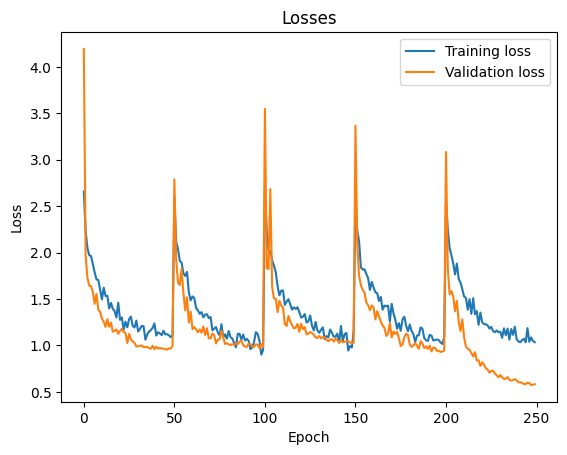

In [22]:
#plot the losses as a function of epochs
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

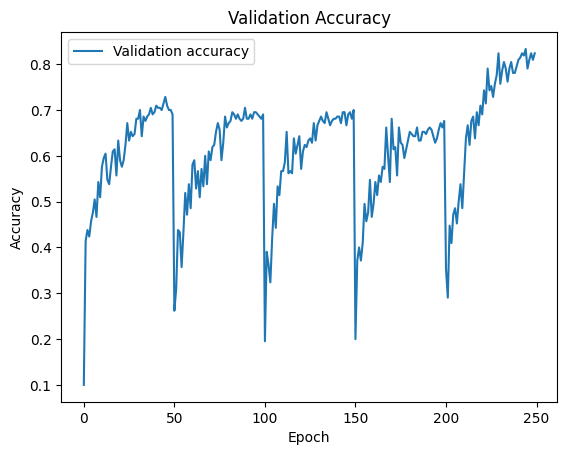

In [23]:
plt.plot(val_accs, label="Validation accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [47]:
def generate_submission_file(model, loader, device):
    model.eval()
    indices_list = list()
    preds = list()
    #pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    pbar = tqdm(total=len(loader))
    with torch.no_grad():
        for i, (data, proj_labels, indices) in enumerate(
                loader):
            data = data.float().to(device)
            label = proj_labels.long().to(device)
            logit = model(data)
            pred = torch.argmax(logit, dim=1)
            indices_list.extend(indices.detach().cpu().numpy().tolist())
            preds.extend(pred.detach().cpu().numpy().tolist())
            print(f'{i} {len(preds)}')
            pbar.update(1)
    pbar.close()
    sample = test_df.iloc[indices_list]
    sample['LABEL'] = preds
    return sample 

In [43]:
test_df.head()

,FNAME
0,06_122845.bin
1,08_925129.bin
2,08_976795.bin
3,06_317230.bin
4,08_386622.bin


In [29]:
#Scan models directory and find all models
import glob
model_paths = glob.glob(model_path + '*.pth')
#print(model_paths)


#Extract the file name only and split it to get the fold number
#Then for each foldNo save the path for the one with the highest saveNo
fold_paths = dict()

for path in model_paths:

    #remove the .pth extension
    #print(os.path.basename(path)[:-4].split('_'))
    splits = os.path.basename(path)[:-4].split('_')
    #BaseName, Date, HHMMSS, Fold, FoldNo, save, saveNo
    foldNo = splits[4]
    saveNo = splits[6]

    if foldNo not in fold_paths:
        fold_paths[foldNo] = path
    else:
        if int(saveNo) > int(os.path.basename(fold_paths[foldNo])[:-4].split('_')[6]):
            fold_paths[foldNo] = path


fold_paths





{'0': '../models\\salsanext_2023-10-16_14-34-54_fold_0_save_19.pth',
 '1': '../models\\salsanext_2023-10-16_14-34-54_fold_1_save_15.pth',
 '2': '../models\\salsanext_2023-10-16_14-34-54_fold_2_save_12.pth',
 '3': '../models\\salsanext_2023-10-16_14-34-54_fold_3_save_9.pth',
 '4': '../models\\salsanext_2023-10-16_14-34-54_fold_4_save_16.pth'}

In [30]:
device

device(type='cuda', index=0)

In [32]:
modelContainer = ModelContainer()
for path in fold_paths:
    print(f'Fold {path}')
    model = SalsaNext(nclasses=N_CLASSES).to(device)
    model.load_state_dict(torch.load(fold_paths[path]))
    model.eval()
    modelContainer.addModel(model)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [45]:
# model = SimpleModel3(num_channels=5, num_classes=N_CLASSES, input_shape=(64, 2048)).to(device)
# model.load_state_dict(torch.load(model_path))
# sample = generate_submission_file(model, test_loader, device)

In [48]:
sample = generate_submission_file(modelContainer, test_loader, device)

0 8


1 16


2 24


3 32


4 40


5 48


6 56


7 64


8 72


9 80


10 88


11 96


12 104


13 112


14 120


15 128


16 136


17 144


18 152


19 160


20 168


21 176


22 184


23 192


24 200


25 208


26 216


27 224


28 232


29 240


30 248


31 256


32 264


33 272


34 280


35 288


36 296


37 304


38 312


39 320


40 328


41 336


42 344


43 352


44 360


45 368


46 376


47 384


48 392


49 400


50 408


51 416


52 424


53 432


54 440


55 448


56 456


57 464


58 472


59 480


60 488


61 496


62 504


63 512


64 520


65 528


66 536


67 544


68 552


69 560


70 568


71 576


72 584


73 592


74 600


75 608


76 616


77 624


78 632


79 640


80 648


81 656


82 664


83 672


84 680


85 688


86 696


87 704


88 712


89 720


90 728


91 736


92 744


93 752


94 760


95 768


96 776


97 784


98 792


99 800


100 808


101 816


102 824


103 832


104 840


105 848


106 856


107 864


108 872


109 880


110 888


111 896


112 904


113 912


114 920


115 928


116 936


117 944


118 952


119 960


120 968


121 976


122 984


123 992


124 1000


125 1008


126 1016


127 1024


128 1032


129 1040


130 1048


131 1056


132 1064


133 1072


134 1080


135 1088


136 1096


137 1104


138 1112


139 1120


140 1128


141 1136


142 1144


143 1152


144 1160


145 1168


146 1176


147 1184


148 1192


100%|██████████| 150/150 [1:26:51<00:00, 34.74s/it]

149 1196


In [49]:
sample.reset_index(drop=True, inplace=True)

In [50]:
sample

,FNAME,LABEL
0,06_122845.bin,15
1,08_925129.bin,16
2,08_976795.bin,9
3,06_317230.bin,0
4,08_386622.bin,0
...,...,...
1191,08_211179.bin,0
1192,08_672278.bin,13
1193,08_399783.bin,13
1194,05_205440.bin,15


In [51]:

sample.to_csv(submission_path, index=None)